In [1]:
import numpy as np
import networkx as nx
import webbrowser
import os
import pickle
import math
import keras
import time
from datetime import timedelta
import datetime
import pandas as pd
import random
from src import utils, trnvaltst_sigmoid_oned, TGCNN_layer, whole_model, whole_model_demographics, create_fake_patients, plot_figures, whole_model_demographics_gradcam
from early_stopping_cv import EarlyStopping
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, roc_auc_score, recall_score
from csv import writer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()

tensorflow version: 2.10.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
no_LSTM = False # True = without LSTM
exponential_scaling = True # True = with exponential
L1_ablation = True # True = with L1 reg
L2_ablation = True # True = with L2 reg
variable_gamma = True
graph_reg_incl = True

num_of_runs = 1
start_num = 1
    
weighted_loss = False # class weighted to deal with imbalance if True
no_timestamp = False # if no_timestamp = True then all values in 3-tensor = 1
activation_type = 'LeakyReLU' #'relu','gelu', 'LeakyReLU'
second_TGCNN_layer = True
demo = True
include_drugs = False
max_timesteps=100

run_name='hip_1999_to_one_year_advance_model'

# strings for hyperparameter searching file
LSTM_str="LSTM excluded" if no_LSTM == True else "LSTM included"
exp_str = "exp excluded" if exponential_scaling == False else "exp included"
timestamp_str = "time elapsed = 1" if no_timestamp == True else "time elapsed"
weighted_loss_str = "weighted_loss" if weighted_loss ==True else "unweighted_loss"
L1_str = "L1 included" if L1_ablation == True else "L1 excluded"
L2_str = "L2 included" if L2_ablation == True else "L2 excluded"
second_layer_str = "Branched model" if second_TGCNN_layer == True else "Unbranched model"

In [3]:
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
num_labels = 1 # number of outcomes -1 
hip_or_knee = 'hip'
class_weights = tf.compat.v2.constant([[0.5, 0.5]]) # 50:50 split for the class weights

# This would be where you would import your data instead of using the `create_fake_patient_df` function
    # Data to train the model on 
cv_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=99, max_nodes=512)
    # Data to test and relicibrate on
test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=99, max_nodes=512)
    # Data to test the recalibrated model on
recal_test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=99, max_nodes=512)

cv_patients

,user,indices,values,num_time_steps,gender,imd_quin,age_at_label_event,replace_type,indices_len
0,1,"[[271, 245, 99], [84, 271, 98], [91, 84, 97], ...","[0.9159167582879828, 0.6496733486926591, 0.034...",40,0,4.0,73.0,none,40
1,2,"[[178, 326, 99], [60, 178, 98], [112, 60, 97],...","[0.1384073331500011, 0.46305858268102473, 0.49...",32,1,4.0,41.0,none,32
2,3,"[[384, 237, 99], [302, 384, 98], [277, 302, 97...","[0.638871095366288, 0.15891873404147228, 0.682...",13,0,3.0,44.0,hip,13
3,4,"[[97, 373, 99], [2, 97, 98], [90, 2, 97], [410...","[0.40024887796394504, 0.8197961598715158, 0.02...",32,0,3.0,49.0,none,32
4,5,"[[317, 358, 99], [2, 317, 98], [229, 2, 97], [...","[0.15143680605421672, 0.6778168803272151, 0.83...",78,0,2.0,53.0,hip,78
...,...,...,...,...,...,...,...,...,...
494,495,"[[174, 446, 99], [359, 174, 98], [351, 359, 97...","[0.9183901517645199, 0.6321926577133822, 0.983...",21,1,4.0,67.0,none,21
495,496,"[[326, 184, 99], [307, 326, 98], [53, 307, 97]...","[0.8890171030466225, 0.6619064779778301, 0.895...",83,1,5.0,45.0,none,83
496,497,"[[67, 361, 99], [314, 67, 98], [161, 314, 97],...","[0.14137404433746736, 0.48450476483902116, 0.0...",91,0,3.0,58.0,hip,91
497,498,"[[288, 268, 99], [313, 288, 98], [165, 313, 97...","[0.31491168552274784, 0.4335294532451185, 0.98...",13,1,5.0,88.0,hip,13


In [4]:
cv_sample_size = len(cv_patients)
test_sample_size = len(test_patients)
recal_test_sample_size = len(recal_test_patients)


indices_len_cv = cv_patients['indices_len'].max() 
indices_len_test = test_patients['indices_len'].max()
indices_len_recal = recal_test_patients['indices_len'].max()
max_indices_len = max(indices_len_cv, indices_len_test, indices_len_recal)

max_indices_len = max_indices_len + 1
print(max_indices_len)

100


In [5]:
cv_y = utils.get_labels_binary(cv_patients)
test_y = utils.get_labels_binary(test_patients)
recal_test_y = utils.get_labels_binary(recal_test_patients)

utils.check_group_sizes(cv_patients, test_patients, cv_y, test_y)

Number of people in the cv input data 499
Number of people in cv label data: 499
Number of people in the test input data 499
Number of people in test label data: 499
Number of patients in each class in cv set:
replace_type
none    250
hip     249
Name: count, dtype: int64

Number of patients in each class in test set:
replace_type
hip     255
none    244
Name: count, dtype: int64


#### Convert list of lists of event codes into Sparse Tensor

In [6]:
cv_input_matrices = utils.create_sparse_tensors(cv_sample_size, cv_patients, max_event_codes, max_indices_len, 'cv')
test_input_matrices = utils.create_sparse_tensors(test_sample_size, test_patients, max_event_codes, max_indices_len, 'test')
recal_test_input_matrices = utils.create_sparse_tensors(recal_test_sample_size, recal_test_patients, max_event_codes, max_indices_len, 'recal_test')

cv : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%
test : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%
recal_test : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%


#### Hyperparameter tuning, model 5-fold-cv training and testing.

In [7]:
%%time
cv_size = int(round(cv_sample_size*0.2)) # 1/5th of cv data
holdout_size = len(test_patients)


for ran_search_num in range(start_num, start_num+num_of_runs):
    print('Run name:', run_name, str(ran_search_num))
    cv_indices = list(range(len(cv_input_matrices)))
    test_indices = list(range(len(test_input_matrices)))
    recal_test_indices = list(range(len(recal_test_input_matrices)))
    #unmatched_test_indices = list(range(len(unmatched_input_matrices)))
    random.shuffle(cv_indices) # shuffles datasets
    random.shuffle(test_indices) # shuffles datasets
    random.shuffle(recal_test_indices)
    #random.shuffle(unmatched_test_indices)
    
    cv_split1_indices = cv_indices[:cv_size]
    cv_split2_indices = cv_indices[cv_size:2*cv_size]
    cv_split3_indices = cv_indices[2*cv_size:3*cv_size]
    cv_split4_indices = cv_indices[3*cv_size:4*cv_size]
    cv_split5_indices = cv_indices[4*cv_size:5*cv_size]


    batch_size = 64

    batched_graphs_split1, batched_labels_split1, batched_cv_split1_indices = utils.batch_set(indice_set=cv_split1_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split2, batched_labels_split2, batched_cv_split2_indices = utils.batch_set(indice_set=cv_split2_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split3, batched_labels_split3, batched_cv_split3_indices = utils.batch_set(indice_set=cv_split3_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split4, batched_labels_split4, batched_cv_split4_indices = utils.batch_set(indice_set=cv_split4_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split5, batched_labels_split5, batched_cv_split5_indices = utils.batch_set(indice_set=cv_split5_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    
    
    batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices = utils.batch_set(indice_set=test_indices, input_matrices=test_input_matrices, 
                                                         labels=test_y.to_numpy(), batchsize=batch_size)
    labels_holdout = [item for sublist in batched_labels_holdout for item in sublist]
    
    batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices = utils.batch_set(indice_set=recal_test_indices, input_matrices=recal_test_input_matrices, 
                                                         labels=recal_test_y.to_numpy(), batchsize=batch_size)
    labels_holdout2 = [item for sublist in batched_labels_holdout2 for item in sublist]
    
#     batched_graphs_unmatch, batched_labels_unmatch, batched_unmatch_indices = utils.batch_set(indice_set=unmatched_test_indices, input_matrices=unmatched_input_matrices, 
#                                                          labels=unmatched_y.to_numpy(), batchsize=batch_size)
#     labels_unmatch = [item for sublist in batched_labels_unmatch for item in sublist]
    

    
    # Save the true labels for analysis later
    file_full_name_true = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_true.npy'
    with open(file_full_name_true, 'wb') as f:
        np.save(f, labels_holdout)
        
    file_full_name_true2 = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout2_true.npy'
    with open(file_full_name_true2, 'wb') as f:
        np.save(f, labels_holdout2)
    
#     file_full_name_true3 = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_unmatch_true.npy'
#     with open(file_full_name_true3, 'wb') as f:
#         np.save(f, labels_unmatch)
    
    
    # split cv data into batches for training
    graphs_train1, graphs_train2, graphs_train3, graphs_train4, graphs_train5, graphs_test1, graphs_test2, \
    graphs_test3, graphs_test4, graphs_test5, labels_train1, labels_train2, labels_train3, labels_train4, \
    labels_train5, labels_test1, labels_test2, labels_test3, labels_test4, labels_test5, indices_train1, \
    indices_train2, indices_train3, indices_train4, indices_train5, indices_test1, indices_test2, indices_test3, \
    indices_test4, indices_test5, \
    = utils.get_cv_groups(batched_graphs_split1, batched_graphs_split2, batched_graphs_split3, batched_graphs_split4, 
                    batched_graphs_split5, batched_labels_split1, batched_labels_split2, batched_labels_split3, 
                    batched_labels_split4, batched_labels_split5, batched_cv_split1_indices, batched_cv_split2_indices, 
                    batched_cv_split3_indices, batched_cv_split4_indices, batched_cv_split5_indices)

    nepochs=1
    lr = random.choice([0.001, 0.005, 0.0001]) # initial learning rate

    out_chans = 16#random.choice([8, 16, 32]) # number of filters
    filter_size = 4#random.choice([3, 4, 6]) # number of time steps/ filter size
    if no_LSTM:
        lstm_h = 0
    else:
        lstm_h = 64#random.choice([16, 32, 64, 128, 256]) # number of LSTM neurons
    linear_size = 128#random.choice([64, 128]) # linear layer output size
    #drop_val = random.choice([0.2, 0.3, 0.4, 0.5])
    drop_val = 0.7#random.choice([0.5, 0.6, 0.7, 0.8, 0.9])
    reg_strength = 0.01#random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
    #reg_strength = random.choice([100, 10, 1, 1e-1, 5e-1])
    graph_reg_strength = 1e1
    


    print(f"Number of epochs: {nepochs}")
    print(f"Learning rate: {lr}")
    print(f"Number of 3D CNN filters: {out_chans}")
    print(f"Filter size: {filter_size}")
    print(f"Number of LSTM neurons: {lstm_h}")
    print(f"Number of fully connected layers: {linear_size}")
    print(f"Dropout value: {drop_val}")
    print(f"Regularisation strength: {reg_strength}")
    print("*"*40)
    

    #############################################
    ####### FOR LOOP FOR CV HERE  ###############
    #############################################
    
    cv_accuracy, cv_auc, cv_cal_slope = [], [], []
    best_metric = 0
    for split in range(0, 5):
        run_split_name = run_name + str(ran_search_num) +"_split" + str(split+1)
        print(run_split_name)
        
        if demo:
            model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
        else:
            model = whole_model.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
    
        early_stopping = EarlyStopping(patience=5, verbose=True)


        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=1000,
            decay_rate=0.9)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        if split+1 == 1:
            batched_graphs_trn, batched_labels_trn = graphs_train1, labels_train1
            batched_graphs_val, batched_labels_val = graphs_test1, labels_test1
            train_indices = indices_train1
            test_indices = indices_test1
            
        elif split+1 == 2:
            batched_graphs_trn, batched_labels_trn = graphs_train2, labels_train2
            batched_graphs_val, batched_labels_val = graphs_test2, labels_test2
            train_indices = indices_train2
            test_indices = indices_test2
            
        elif split+1 == 3:
            batched_graphs_trn, batched_labels_trn = graphs_train3, labels_train3
            batched_graphs_val, batched_labels_val = graphs_test3, labels_test3
            train_indices = indices_train3
            test_indices = indices_test3
            
        elif split+1 == 4:
            batched_graphs_trn, batched_labels_trn = graphs_train4, labels_train4
            batched_graphs_val, batched_labels_val = graphs_test4, labels_test4
            train_indices = indices_train4
            test_indices = indices_test4
            
        elif split+1 == 5:
            batched_graphs_trn, batched_labels_trn = graphs_train5, labels_train5
            batched_graphs_val, batched_labels_val = graphs_test5, labels_test5
            train_indices = indices_train5
            test_indices = indices_test5
            
        
        start_time = time.monotonic()

        train_loss_epochs, train_acc_epochs, train_prec_epochs, train_recall_epochs, train_f1_epochs, train_auc_epochs = [],[],[],[],[],[]
        #train_indiv_acc_epochs, train_indiv_prec_epochs, train_indiv_recall_epochs, train_indiv_f1_epochs, train_indiv_auc_epochs = [],[],[],[],[]
        val_loss_epochs, val_acc_epochs, val_prec_epochs, val_recall_epochs, val_f1_epochs, val_auc_epochs = [],[],[],[],[],[]
        #val_indiv_acc_epochs, val_indiv_prec_epochs, val_indiv_recall_epochs, val_indiv_f1_epochs, val_indiv_auc_epochs = [],[],[],[],[]

        for epoch in range(nepochs):
            #if epoch % 10 == 0:
            print(f"\nEpoch {epoch+1}/{nepochs}")

            # Iterate over the batches of the dataset.
            train_loss_list, train_acc_list, train_prec_list, train_recall_list, train_f1_list, train_auc_list = [],[],[],[],[],[]
            train_logits_list = []

            for x_batch_train, y_batch_train, train_indices_list in zip(batched_graphs_trn, batched_labels_trn, train_indices):
                # need to get one list at a time from the list of lists   
                trn_demo_vals, trn_demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, train_indices_list, demo)
                #print(x_batch_train)
                if demo == False:
                    trn_demo_vals = None
                    trn_demo_list = None
                
                y_batch_train=np.array(y_batch_train)
                trn_logits, trn_loss, trn_acc, trn_prec, trn_recall, trn_auc, trn_f1, \
                model = trnvaltst_sigmoid_oned.train_step(x_batch_train, y_batch_train, trn_demo_vals,
                                                        reg_strength,class_weights,model,L1_ablation,L2_ablation, 
                                                       graph_reg_strength, graph_reg_incl, exponential_scaling,
                                                       weighted_loss, variable_gamma, optimizer, demo)

                train_loss_list.append(trn_loss)
                train_acc_list.append(trn_acc)
                train_prec_list.append(trn_prec)
                train_recall_list.append(trn_recall)
                train_auc_list.append(trn_auc)
                train_f1_list.append(trn_f1)
                train_logits_list = train_logits_list + trn_logits.numpy().tolist()

            if variable_gamma and (exponential_scaling==True):
                gamma_val = float(model.tg_conv_layer1.gammat.numpy())
                print("Gamma:", gamma_val)
                if second_TGCNN_layer:
                    gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                    print("Gamma 2:", gamma_val2)


            print("\nTRAINING METRICS:")
            print(f"Training AUC: {np.mean(train_auc_list):.4f}")
            print(f"Train loss {np.mean(train_loss_list):.4f}")
            print(f"Train accuracy: {np.mean(train_acc_list) :.4%}")

            flattened_train_labels = [int(item) for sublist in batched_labels_trn for array in sublist for item in array]
            train_cal_slope = utils.calibration_slope(flattened_train_labels, train_logits_list)
            print(f"Train calibration slope: {train_cal_slope:.4f}")


            # Validation loop
            val_loss_list, val_acc_list,  val_prec_list, val_recall_list, val_auc_list, val_f1_list = [],[],[],[],[],[]
            val_logits_list = []
            for x_batch_val, y_batch_val, test_indices_list in zip(batched_graphs_val, batched_labels_val, test_indices):
                
                test_demo_vals, test_demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, test_indices_list, demo)                
                
                if demo == False:
                    test_demo_vals = None

                # print(test_demo_vals)
                # print(test_demo_vals.shape)
                
                val_logits, val_loss, val_acc, val_prec, val_recall, val_auc, val_f1, \
                model = trnvaltst_sigmoid_oned.val_step(x_batch_val, y_batch_val, test_demo_vals, reg_strength, 
                                                  class_weights, model, L1_ablation, L2_ablation, 
                                                  graph_reg_strength, graph_reg_incl, weighted_loss, demo)

                val_loss_list.append(val_loss)
                val_acc_list.append(val_acc)
                val_prec_list.append(val_prec)
                val_recall_list.append(val_recall) 
                val_auc_list.append(val_auc)
                val_f1_list.append(val_f1)
                val_logits_list = val_logits_list + val_logits.numpy().tolist()
            
            
            
            
            # Saves the logits if the AUC improves
            improved_metric = False
            if np.mean(val_auc_list) > best_metric:
                best_metric = np.mean(val_auc_list)
                improved_metric = True

            print("\nVALIDATION METRICS:")
            print(f"Validation AUC: {np.mean(val_auc_list):.4f}")
            print(f"Validation loss: {np.mean(val_loss_list):.4f}")
            print(f"Validation accuracy: {np.mean(val_acc_list) :.4%}")

            flattened_val_labels = [int(item) for sublist in batched_labels_val for array in sublist for item in array]
            val_cal_slope = utils.calibration_slope(flattened_val_labels, val_logits_list)
            print(f"Validation calibration slope: {val_cal_slope:.4f}")
            
            #plot_figures.draw_confusion_mat(y_batch_val, val_logits, ['none','hip'], run_name=None, ran_search_num=1111, data_type="V")
            #plot_figures.draw_calibration_curve(np.array(flattened_val_labels), np.array(val_logits_list), run_name=None, ran_search_num=1111)

            print("="*50)
            # get the average metric from ONE epoch
            ave_epoch_train_loss, ave_epoch_train_acc, ave_epoch_train_auc, ave_epoch_train_prec, ave_epoch_train_recall, ave_epoch_train_f1 = np.mean(train_loss_list), np.mean(train_acc_list), np.mean(train_auc_list), np.mean(train_prec_list), np.mean(train_recall_list), np.mean(train_f1_list)
            ave_epoch_val_loss, ave_epoch_val_acc, ave_epoch_val_auc, ave_epoch_val_prec, ave_epoch_val_recall, ave_epoch_val_f1 = np.mean(val_loss_list), np.mean(val_acc_list), np.mean(val_auc_list), np.mean(val_prec_list), np.mean(val_recall_list), np.mean(val_f1_list)        


            #print(optimizer.get_config())

            # save the average (from one epoch) to the list of ALL epochs
            utils.metric_save(ave_epoch_train_loss, train_loss_epochs, ave_epoch_val_loss, val_loss_epochs) #losses
            utils.metric_save(ave_epoch_train_acc, train_acc_epochs, ave_epoch_val_acc, val_acc_epochs) # acc
            utils.metric_save(ave_epoch_train_auc, train_auc_epochs, ave_epoch_val_auc, val_auc_epochs) # auc        
            utils.metric_save(ave_epoch_train_prec, train_prec_epochs, ave_epoch_val_prec, val_prec_epochs) # prec
            utils.metric_save(ave_epoch_train_recall, train_recall_epochs, ave_epoch_val_recall, val_recall_epochs) # recall
            utils.metric_save(ave_epoch_train_f1, train_f1_epochs, ave_epoch_val_f1, val_f1_epochs) #f1


            early_stopping_metric = val_loss_list # metric that is used to determine if the model should stop training
            early_stopping(np.mean(early_stopping_metric), train_loss_list, val_loss_list, 
                           train_cal_slope, val_cal_slope,
                           train_acc_list, val_acc_list,  
                           train_auc_list, val_auc_list,
                           #train_auc_indiv_ave, val_auc_indiv_ave,
                           train_prec_list, val_prec_list,
                           #train_prec_indiv_ave, val_prec_indiv_ave,
                           train_recall_list, val_recall_list,
                           #train_recall_indiv_ave, val_recall_indiv_ave,
                           train_f1_list, val_f1_list,
                           #train_f1_indiv_ave, val_f1_indiv_ave, 
                           model, run_name+str(ran_search_num),
                           batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices,
                           batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices,
                           #batched_graphs_unmatch, batched_labels_unmatch, batched_unmatch_indices,
                           reg_strength,
                           class_weights, L1_ablation, L2_ablation, graph_reg_strength, graph_reg_incl, weighted_loss, 
                           improved_metric, test_patients, recal_test_patients, 
                           #unmatched_pats, 
                           demo, save_filters = False)

            if early_stopping.checkpoint_made:

                checkpoint_train_loss, checkpoint_val_loss, \
                checkpoint_train_cal_slope, checkpoint_val_cal_slope, \
                checkpoint_train_acc, checkpoint_val_acc, \
                checkpoint_train_auc, checkpoint_val_auc, \
                checkpoint_train_prec, checkpoint_val_prec,  \
                checkpoint_train_recall, checkpoint_val_recall, \
                checkpoint_train_f1, checkpoint_val_f1 = early_stopping.print_checkpoint_metric(train_loss_list,
                                                                            val_loss_list, 
                                                                            train_cal_slope, val_cal_slope,
                                                                            train_acc_list, val_acc_list, 
                                                                            train_auc_list, val_auc_list, 
                                                                            train_prec_list, val_prec_list,                                    
                                                                            train_recall_list, val_recall_list,                                       
                                                                            train_f1_list, val_f1_list)


            if early_stopping.early_stop:
                print("Early stopping")
                break

        

        if variable_gamma and (exponential_scaling==True):
            gamma_val = float(model.tg_conv_layer1.gammat.numpy())
            print("Gamma:", gamma_val)
            if second_TGCNN_layer:
                gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                print("Gamma 2:", gamma_val2)
                
        else:
            gamma_val = 'N/A'

        end_time = time.monotonic()
        time_taken = timedelta(seconds=end_time - start_time)

        list_for_csv = [run_split_name+"_"+str(ran_search_num), nepochs, epoch+1, str(time_taken), lr, out_chans, filter_size, 
                        lstm_h, reg_strength,
                       linear_size, drop_val, batch_size,

                        min(train_loss_epochs), max(train_loss_epochs), min(val_loss_epochs), 
                        max(val_loss_epochs), checkpoint_train_loss, checkpoint_val_loss,                    

                        min(train_auc_epochs), max(train_auc_epochs), min(val_auc_epochs), 
                        max(val_auc_epochs), checkpoint_train_auc, checkpoint_val_auc,                  

                        min(train_acc_epochs), max(train_acc_epochs), min(val_acc_epochs), 
                        max(val_acc_epochs), checkpoint_train_acc, checkpoint_val_acc,

                        min(train_prec_epochs), max(train_prec_epochs), min(val_prec_epochs), 
                        max(val_prec_epochs), checkpoint_train_prec, checkpoint_val_prec,   

                        min(train_recall_epochs), max(train_recall_epochs), min(val_recall_epochs), 
                        max(val_recall_epochs), checkpoint_train_recall, checkpoint_val_recall,  

                        min(train_f1_epochs), max(train_f1_epochs), min(val_f1_epochs), 
                        max(val_f1_epochs), checkpoint_train_f1, checkpoint_val_f1, 

                        gamma_val, 
                        checkpoint_train_cal_slope, checkpoint_val_cal_slope,
                        activation_type, LSTM_str, exp_str, timestamp_str, weighted_loss_str, L1_str, L2_str,
                        second_layer_str]



        with open('tgcnn_hip_and_knee_results.csv', 'a', newline='') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(list_for_csv)
            f_object.close()




        print("\nCHECKPOINTED RESULTS")
        print(f"Train loss: {checkpoint_train_loss:.4f}") # average loss from the epoch
        print(f"Train AUC: {checkpoint_train_auc:.4%}\n")
        print(f"Val loss: {checkpoint_val_loss:.4f}") # average loss from the epoch
        print(f"Val AUC: {checkpoint_val_auc:.4%}\n")

        print("="*50)
        print("="*50)
        
        cv_accuracy.append(checkpoint_val_acc)
        cv_auc.append(checkpoint_val_auc)
        cv_cal_slope.append(checkpoint_val_cal_slope)

        break # to run one fold only
        
    print(f"5-fold CV Accuracy on (Validation Set): {np.mean(cv_accuracy):.4f} +/- {np.std(cv_accuracy):.4f}")
    print(f"5-fold CV AUC on (Validation Set): {np.mean(cv_auc):.4f} +/- {np.std(cv_auc):.4f}")
    print(f"5-fold CV Calibration Slope (Validation Set): {np.mean(cv_cal_slope):.4f} +/- {np.std(cv_cal_slope):.4f}")
    print("*"*100)

    # class_names = ['none', 'hip']
#     plot_figures.plot_loss_curve(train_loss = train_loss_epochs, val_loss = val_loss_epochs, test_lost = test_loss_epochs, 
#                     run_name=run_split_name, ran_search_num=ran_search_num)


    # # open the proba file and then plot the figures for the test data
    # # The model is tested during early stopping
    # with open('pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_proba.npy', 'rb') as f:
    #     test_logits = np.load(f)

    #plot_figures.draw_confusion_mat(labels_holdout, test_logits, class_names, run_name, ran_search_num)
    #plot_figures.draw_calibration_curve(labels_holdout, test_logits, run_name, ran_search_num)
    


Run name: hip_1999_to_one_year_advance_model 1
Number of epochs: 1
Learning rate: 0.005
Number of 3D CNN filters: 16
Filter size: 4
Number of LSTM neurons: 64
Number of fully connected layers: 128
Dropout value: 0.7
Regularisation strength: 0.01
****************************************
hip_1999_to_one_year_advance_model1_split1
normalised gamma [[0.00951405]]
normalised gamma [[0.01403162]]

Epoch 1/1
Gamma: 0.017042163759469986
Gamma 2: 0.02483130432665348

TRAINING METRICS:
Training AUC: 0.4996
Train loss 4470.4390
Train accuracy: 49.0969%
Train calibration slope: -0.0479

VALIDATION METRICS:
Validation AUC: 0.5000
Validation loss: 2394.1782
Validation accuracy: 58.0000%
Validation calibration slope: 0.5349
Validation loss decreased (inf --> 2394.178223).
Feature maps from CNN saving...
Feature Maps Saved
Model weights saving...

TEST/HOLDOUT METRICS:
Test AUC scores: 0.5000
Test accuracy: 51.1169%
Test Recall: 1.0000
Test Precision: 0.5112
Test F1: 0.6750
Test calibration slope: 0.4

In [8]:
# cnn_out = np.load("hip_1999_to_one_year_advance_model1_CNN_layer.npy") # load the feature maps
# This might be a poor way to do this when using a class as we can just grab the feature maps for each patient input

In [9]:
model.summary()

Model: "tgcnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tg_conv_layer1 (TGCNN_layer  multiple                 16777217  
 )                                                               
                                                                 
 tg_conv_layer2 (TGCNN_layer  multiple                 16777217  
 )                                                               
                                                                 
 batch_normalization (BatchN  multiple                 388       
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 196       
 hNormalization)                                                 
                                                                 
 LeakyReLU (Activation)      multiple                 

### Save model weights test

In [10]:
model.save_weights('saved_weights_test')

In [11]:
model.load_weights('saved_weights_test')

### GradCAM

In [12]:
# Generate an example patient of number n
n= 0

i_list = cv_patients.iloc[n]['indices'] # indices from patient cell
v_list = cv_patients.iloc[n]['values'] # values from patient cell

individual_sparse = tf.sparse.SparseTensor(i_list, v_list, (max_event_codes, max_event_codes, max_indices_len))

# Adding the sparse tensor to a list of all the tensors
ordered_indiv = tf.sparse.reorder(individual_sparse) # reorder required for tensor to work (no effect to outcome)
print(tf.sparse.expand_dims(ordered_indiv,axis=0))
input_4d = tf.sparse.expand_dims(ordered_indiv,axis=0)

outcome = cv_patients.iloc[n]['replace_type']

def classify_outcome(outcome):
    return 1 if outcome == 'hip' else 0

outcome_bin = classify_outcome(outcome)




# patient_dense_tensor = tf.sparse.to_dense(ordered_indiv)
#patient_dense_tensor

#demo_vals, demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, train_indices_list, demo)

demos = cv_patients[['gender', 'imd_quin', 'age_at_label_event']].iloc[n]
demos_z = demos.copy()
demos_z['age_zscore'] = 2
demos_z = demos_z.apply(pd.to_numeric)  
demo_vals = demos_z[['gender', 'imd_quin', 'age_zscore']].values 

demo = demos.apply(pd.to_numeric)
demo_list = demo[['gender', 'imd_quin', 'age_at_label_event']].values.tolist()
demo_tensor = tf.convert_to_tensor([demo_vals])

# print(demo_tensor)
# print(demo_list)

SparseTensor(indices=tf.Tensor(
[[  0   6 455  63]
 [  0  10 321  80]
 [  0  12 340  87]
 [  0  24 441  70]
 [  0  34 192  72]
 [  0  38  91  96]
 [  0  77 414  78]
 [  0  84 271  98]
 [  0  91  84  97]
 [  0 117 337  94]
 [  0 118 360  76]
 [  0 118 492  92]
 [  0 154 395  67]
 [  0 192 451  73]
 [  0 231 427  65]
 [  0 246 118  75]
 [  0 271 245  99]
 [  0 276 324  85]
 [  0 304 397  90]
 [  0 321 332  81]
 [  0 324  12  86]
 [  0 332 358  82]
 [  0 337  38  95]
 [  0 340 416  88]
 [  0 358 411  83]
 [  0 360  77  77]
 [  0 395 509  68]
 [  0 397 118  91]
 [  0 411 276  84]
 [  0 411 484  60]
 [  0 414  10  79]
 [  0 416 304  89]
 [  0 427 154  66]
 [  0 441  34  71]
 [  0 451 246  74]
 [  0 455 231  64]
 [  0 478   6  62]
 [  0 484 478  61]
 [  0 492 117  93]
 [  0 509  24  69]], shape=(40, 4), dtype=int64), values=tf.Tensor(
[0.33329886 0.97568274 0.20642503 0.7407473  0.1220587  0.1712861
 0.06207549 0.64967334 0.03414216 0.777004   0.13140804 0.90982985
 0.45069    0.9109016  0.5

In [13]:
logits = model(input_4d, demo_tensor, training=False)
print(logits)

grads = model.dy_du_branch1
grads2 = model.dy_du_branch2
print(grads.shape)
print(grads2.shape) # this won't be the same shape as the stride size is different ((100 - 4)/2)+1 = ((timesteps - filter_size)/stride)+1

tf.Tensor([[0.07183398]], shape=(1, 1), dtype=float32)
(1, 16, 97)
(1, 16, 49)


In [14]:
grads

<tf.Tensor: shape=(1, 16, 97), dtype=float32, numpy=
array([[[-4.90721144e-11, -6.74418507e-11, -9.06648784e-11, ...,
          4.24042810e-03,  5.90863172e-03,  8.44908226e-03],
        [ 3.25442590e-11,  2.89474347e-11,  2.24897462e-11, ...,
         -3.97794740e-03, -5.06395334e-03, -6.41711382e-03],
        [ 5.26408084e-12,  4.01566627e-12,  2.79935103e-12, ...,
         -1.26242321e-02, -1.62368473e-02, -2.08760984e-02],
        ...,
        [-2.26598219e-11, -1.36384549e-11,  6.19049950e-13, ...,
          4.42343205e-03,  4.35073487e-03,  3.73228895e-03],
        [ 9.97388422e-11,  1.28433653e-10,  1.64106756e-10, ...,
         -8.02589115e-03, -9.58695263e-03, -1.11776963e-02],
        [-1.03019204e-10, -1.35600378e-10, -1.76307718e-10, ...,
          1.65057601e-03,  4.44054790e-03,  9.31118149e-03]]],
      dtype=float32)>

### Functions for Graph Drawing

In [15]:
def create_edges_df_gc(patient_graph:np.array):
    """Create a DataFrame of the edges of the patient graph, including the start and end nodes and the time 
    between visits. For Grad-CAM model.

    Args:
        patient_graph (np.array): 3D numpy array showing the patients health codes over time.

    Returns:
        DataFrame: with columns start_node, end_node, time_between.
    """

    # Get the indices of non-zero elements
    patient_graph = np.round(patient_graph.numpy(), 4)
    t_indices, i_indices, j_indices = np.nonzero(patient_graph)
    non_zero_values = []
    for t, i, j in zip(t_indices, i_indices, j_indices):
        non_zero_values.append(patient_graph[t, i, j])
    #print("Non-zero values", non_zero_values)
    if not non_zero_values:
        print("Error: Subgraph does not contain any values.")

    # Calculate start_node_v and end_node_v
    start_node_v = np.where(t_indices == 0, 0, t_indices)
    end_node_v = start_node_v + 1

    edges_df = pd.DataFrame({
        'start_node': [f'{i}_v{start_v}' for i, start_v in zip(i_indices, start_node_v)],
        'end_node': [f'{j}_v{end_v}' for j, end_v in zip(j_indices, end_node_v)],
        'time_between': non_zero_values
    })
    
    return edges_df

def extract_visit_number(s:str):
    """Extract the visit number from a string

    Args:
        s (str): string to split

    Returns:
        int: visit number
    """
    return int(s.split('_')[1][1:])

def create_position_df_gc(edges_df:np.array):
    """Create a DataFrame to find the number of nodes per visit. For Grad-CAM model.

    Args:
        edges_df (pd.DataFrame): DataFrame with columns start_node, end_node, time_between.

    Returns:
        pd.DataFrame: with columns showing node name (node), visit number (x), node number in visits (cumulative count),
        and maximum codes per visit.
    """
    pos_df = edges_df[['start_node', 'end_node']].stack().drop_duplicates().reset_index(drop=True)
    pos_df = pos_df.to_frame(name='node')
    pos_df['x'] = pos_df['node'].apply(extract_visit_number)
    pos_df['cumulative_count'] = pos_df.groupby('x').cumcount()
    pos_df['max_codes_per_visit'] = pos_df.groupby('x')['cumulative_count'].transform('max') + 1

    return pos_df

def generate_pos_sequence(x:int):
    """Generate a list of lists to get y coordinate positions for the nodes
     based on the number of events recorded per visit.

    Args:
        x (int): maximum number of nodes in any one visit

    Returns:
        List: List of lists of y coordinates index mapping to the max nodes for
               each visit.
    """
    sequence = []
    for i in range(x):
        if i % 2 == 0:  # Even index, include zero
            sequence.append(list(range(-i // 2, i // 2 + 1)))
        else:  # Odd index, exclude zero
            sublist = list(range(-(i // 2 + 1), i // 2 + 2))
            sublist.remove(0)
            sequence.append(sublist)
    return sequence


def get_pos_y_value_per_node(row, pos_list:list):
    """Get the y position for each node. Use max_codes_per_visit column to select the sublist 
    and the cumulative_count to get the position from the sublist.

    Args:
        row (pd.Series): row of the DataFrame

    Returns:
        int: y coordinate position 
    """
    cum_count = row['cumulative_count']
    max_codes = row['max_codes_per_visit']
    return pos_list[max_codes - 1][cum_count]

def map_y_coord_to_node(pos_df:pd.DataFrame, pos_list:list):
    """Map the y coordinates to the relevant node and correct row.

    Args:
        pos_df (pd.DataFrame): columns with node name and x coordinate.
        pos_list (list of lists): List of lists of y coordinates index mapping to the max nodes for
               each visit.

    Returns:
        pd.DataFrame: dataframe with x and y coordinates for node plotting.
    """
    pos_df['y'] = pos_df.apply(lambda row: get_pos_y_value_per_node(row, pos_list), axis=1)
    return pos_df

def create_pos_dict(pos_df:pd.DataFrame):
    """Make a dictionary with the node name as the key and the x and y coordinates 
    as a tuple value.

    Args:
        pos_df (pd.DataFrame): dataframe with columns for the node name, x coordinates,
        and y coordinates.

    Returns:
        dict: dictionary of node: (x,y)
    """
    # the visit number is x and the y value is the number of nodes with the same visit number
    pos = pos_df.set_index('node')[['x', 'y']].apply(tuple, axis=1).to_dict()
    return pos

def draw_gc_pat_graph(edges_df:pd.DataFrame, pos_dict:pd.DataFrame, graph_name:str, pat_outcome, stream_num:int=1):
    """Draw an individual patient's subgraph graph using NetworkX.

    Args:
        edges_df (pd.DataFrame): Dataframe with information about edges including: start and end nodes, and edge_label.
        pos_dict (dictionary): dictionary with x and y coordinates for each node:(x,y)
    """
    # Convert df to list of tuples for Networkx
    edges = []
    for _, row in edges_df.iterrows():
        edge = (row['start_node'], row['end_node'], {'edge_label': np.round(row['time_between']*30.4167).astype(int)}) # to get days instead of months * 30.4167
        edges.append(edge)

    G = nx.DiGraph()
    G.add_edges_from(edges)


    # Prepare edge colors, widths, and labels based on attributes
    edge_labels = {(u, v): G[u][v]['edge_label'] for u, v in G.edges()}


    years_in_advance = "5"
    # Draw the graph
    plt.figure(figsize=(edges_df['start_node'].nunique()+2, 8))
    nx.draw(G, pos_dict, with_labels=True, node_size=3000, node_color="lightblue", edge_color='grey', width=0.5, font_size=10, font_weight="bold", arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos_dict, edge_labels=edge_labels, font_color='blue', font_size=10, font_weight='bold')
    if pat_outcome == 'hip':
        out_print = f'Patient will likely need a hip replacement in {years_in_advance} years time'
    else:
        out_print = f'It is unlikely this patient will need a hip replacement in {years_in_advance} years time'
    plt.title(f"Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement - Stream {stream_num}\n{out_print}")
    plt.savefig(f"{graph_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

def create_scrollable_html(image_path, html_path):
    # HTML template with a scrollable container
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <style>
            .scrollable-container {{
                width: 100%;
                overflow-x: scroll;
                white-space: nowrap;
            }}
            .scrollable-container img {{
                display: block;
            }}
        </style>
        <title>Graph for Patient Subgraph</title>
    </head>
    <body>
        <div class="scrollable-container">
            <img src="{image_path}" alt="NetworkX Graph">
        </div>
    </body>
    </html>
    """

    # Write the HTML content to a file
    with open(html_path, 'w') as file:
        file.write(html_content)

### Draw graph

#### Branch 1

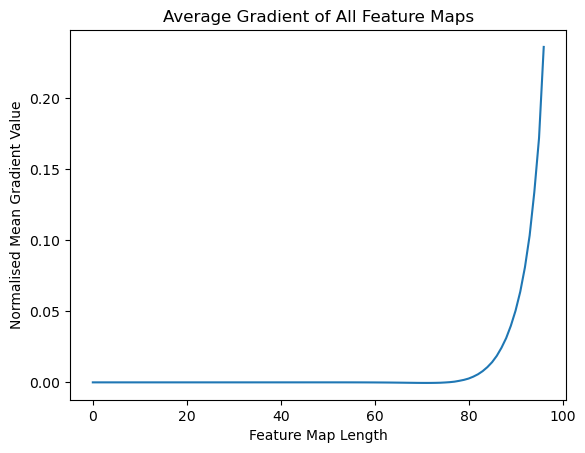

In [16]:
# overall measure average of all features

squeezed = tf.squeeze(grads)
squeezed = np.array(squeezed)
mean_features = np.mean(squeezed, axis=0)
norm_features = mean_features/np.sum(mean_features)

plt.plot(norm_features)
plt.title("Average Gradient of All Feature Maps")
plt.xlabel("Feature Map Length")
plt.ylabel("Normalised Mean Gradient Value")
plt.show()



96
100
(100, 512, 512)
  start_node end_node  time_between
0     245_v0   271_v1        0.9159
1     271_v1    84_v2        0.6497
2      84_v2    91_v3        0.0341
3      91_v3    38_v4        0.1713


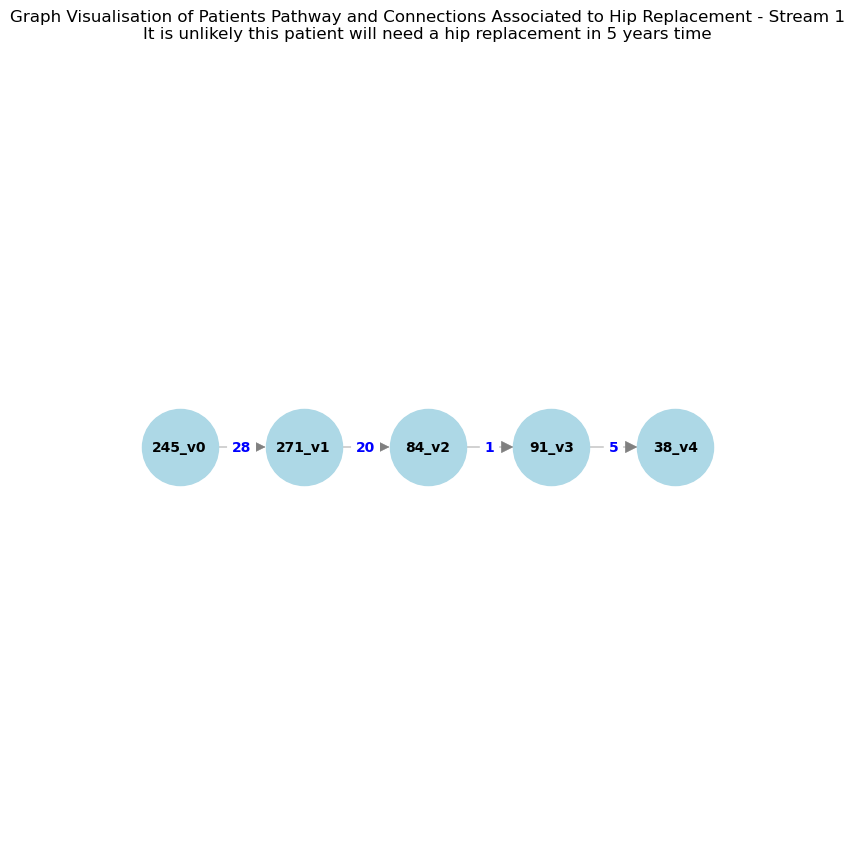

Graph image saved as pat_graph.png
HTML file saved as index.html


True

In [17]:
# Get the index of the with the largest number
max_val_idx = np.argmax(norm_features)
print(max_val_idx)

# Get the indexes for the respective filter in terms of the timesteps i.e. index + filter size -1 
filter_size=4
timestep_max_idx = max_val_idx + filter_size
print(timestep_max_idx)


# Turn the sparse input graph into a dense graph
dense_tensor = tf.sparse.to_dense(ordered_indiv) # ordered_indiv is before the extra dimension is added for batching
dense_tensor

# Reshape to match graph visualisation code (and how I picture it in my noggin)
dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
#print(dense_tensor.shape)

# Flip the graph so the most recent timesteps are at the front rather than the back
dense_tensor = np.flip(dense_tensor, axis=0)

print(dense_tensor.shape)

# Get the chunk of the input graph that corresponds to these timesteps
max_visits = 100
pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-max_val_idx, :, :] # this need to be 100 minus these values as the tensor has been flipped
#print(pat_subgraph)



## Turn these input tensors into a NetworkX graph

# Get the edges for the graph
edges_df = create_edges_df_gc(pat_subgraph)
print(edges_df)

# Get the node positions for the graph
pos_df = create_position_df_gc(edges_df)
pos_list = generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = map_y_coord_to_node(pos_df, pos_list)
pos_dict = create_pos_dict(pos_df)
# Draw the graph and display on HTML
graph_name = 'pat_graph'
image_path = graph_name+'.png'
html_path = 'index.html'
draw_gc_pat_graph(edges_df, pos_dict, graph_name=graph_name, pat_outcome=outcome)
create_scrollable_html(image_path, html_path)
print(f"Graph image saved as {image_path}")
print(f"HTML file saved as {html_path}")

# Open the HTML file
file_url = 'file://' + os.path.realpath(html_path)
webbrowser.open(file_url)

### Branch 2

In [18]:
# # If we're using the two stream model
# if second_TGCNN_layer:
#     squeezed2 = tf.squeeze(grads2)
#     squeezed2 = np.array(squeezed2)
#     mean_features2 = np.mean(squeezed2, axis=0)
#     norm_features2 = mean_features2/np.sum(mean_features2)

#     plt.plot(norm_features2)
#     plt.title("Average Gradient of All Feature Maps from Second Stream")
#     plt.xlabel("Feature Map Length")
#     plt.ylabel("Normalised Mean Gradient Value")
#     plt.show()



#     # Get the index of the with the largest number
#     max_val_idx = np.argmax(norm_features2)
#     print(max_val_idx)

#     # Get the indexes for the respective filter in terms of the timesteps i.e. index + filter size -1 
#     timestep_max_idx = max_val_idx + filter_size
#     print(timestep_max_idx)


#     # Turn the sparse input graph into a dense graph
#     dense_tensor = tf.sparse.to_dense(ordered_indiv) # ordered_indiv is before the extra dimension is added for batching

#     # Reshape to match graph visualisation code (and how I picture it in my noggin)
#     dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
#     #print(dense_tensor.shape)

#     # Flip the graph so the most recent timesteps are at the front rather than the back
#     dense_tensor = np.flip(dense_tensor, axis=0)

#     print(dense_tensor.shape)

#     # Get the chunk of the input graph that corresponds to these timesteps
#     max_visits = 100
#     pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-max_val_idx, :, :] # this need to be 100 minus these values as the tensor has been flipped
#     #print(pat_subgraph)


#     ## Turn these input tensors into a NetworkX graph

#     # Get the edges for the graph
#     edges_df = create_edges_df_gc(pat_subgraph)
#     print(edges_df)

#     # Get the node positions for the graph
#     pos_df = create_position_df_gc(edges_df)
#     pos_list = generate_pos_sequence(pos_df['max_codes_per_visit'].max())
#     pos_df = map_y_coord_to_node(pos_df, pos_list)
#     pos_dict = create_pos_dict(pos_df)
#     # Draw the graph...
#     draw_gc_pat_graph(edges_df, pos_dict, stream_num=2)


### Seperate Feature Map Drawing

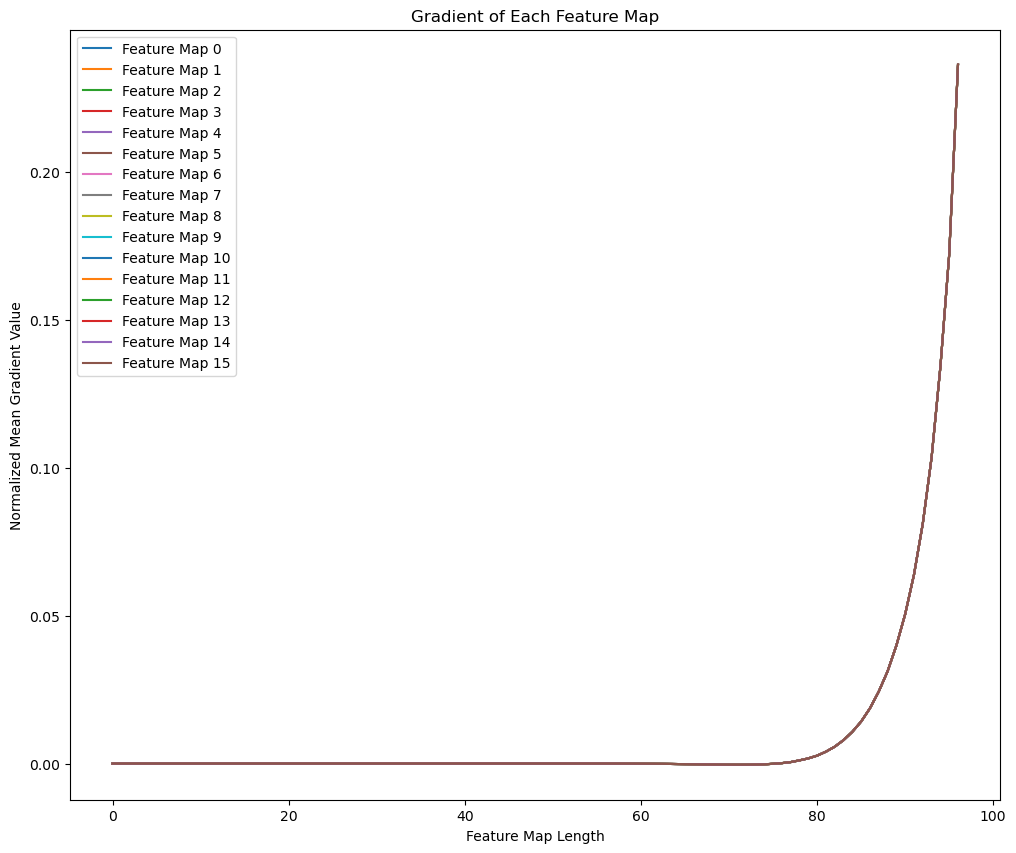

In [19]:
# look at each feature map separately

plt.figure(figsize=(12, 10))
for map in range(grads.shape[1]):
    np_grads = np.array(grads[0, map, :])
    norm_grads = np_grads / np.sum(np_grads)
    plt.plot(norm_features, label=f'Feature Map {map}')

plt.title("Gradient of Each Feature Map")
plt.xlabel("Feature Map Length")
plt.ylabel("Normalized Mean Gradient Value")
plt.legend(loc='upper left')  # This will automatically use the labels specified in plt.plot
plt.show()

In [20]:
# def compute_gradcam_3d(model, input_data, input_demo_data, layer_name):

#     probs = model(input_4d, demo_tensor, training=False)

#     grads = model.dy_du
#     guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

#     conv_outputs = conv_outputs[0]
#     guided_grads = guided_grads[0]

#     weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

#     gradcam = np.zeros(conv_outputs.shape[0:3], dtype=np.float32)

#     for i, w in enumerate(weights):
#         gradcam += w * conv_outputs[:, :, :, i]

#     input_shape = input_data.shape[1:4]
#     zoom_factors = [input_shape[i] / gradcam.shape[i] for i in range(3)]
#     gradcam = zoom(gradcam, zoom_factors)
#     gradcam = np.maximum(gradcam, 0)
#     gradcam = gradcam / gradcam.max()
#     return gradcam


# # Compute Grad-CAM for the CNN layer
# gradcam = compute_gradcam_3d(model, tf.sparse.expand_dims(ordered_indiv, axis=0), tf.expand_dims(demo_tensor, axis=0), layer_name='tg_conv_layer1')a

In [21]:
# def compute_gradcam_3d(model, input_data):
#     # Function to build the gradient model dynamically
#     def build_gradient_model(model, input_data):
#         print(type(input_data))
#         print(input_data.shape)
#         inputs = tf.keras.Input(shape=input_data.shape[1:], sparse=True)  # Define input shape dynamically
#         print(inputs.shape)
#         x = model.layers[0](inputs)
#         print(x.shape)

#         # Create a new model up to the specified layer and also include the full model output
#         truncated_model = tf.keras.Model(inputs=[inputs], outputs=[x, model(inputs)])
        
#         return truncated_model



#     # Build the gradient model
#     grad_model = build_gradient_model(model, input_data)

#     with tf.GradientTape() as tape:
#         print(grad_model.summary())
#         conv_outputs, predictions = grad_model(input_data)
#         class_idx = tf.argmax(predictions[0])
#         loss = predictions[:, class_idx]

#     grads = tape.gradient(loss, conv_outputs)
#     guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

#     conv_outputs = conv_outputs[0]
#     guided_grads = guided_grads[0]

#     weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

#     gradcam = np.zeros(conv_outputs.shape[0:3], dtype=np.float32)

#     for i, w in enumerate(weights):
#         gradcam += w * conv_outputs[:, :, :, i]

#     input_shape = input_data.shape[1:4]
#     zoom_factors = [input_shape[i] / gradcam.shape[i] for i in range(3)]
#     gradcam = zoom(gradcam, zoom_factors)
#     gradcam = np.maximum(gradcam, 0)
#     gradcam = gradcam / gradcam.max()
#     return gradcam


# # Compute Grad-CAM for the CNN layer
# gradcam = compute_gradcam_3d(no_demo_model, tf.sparse.expand_dims(ordered_indiv, axis=0))

In [22]:
for var in model.variables:
    print(var.name)
    print(var.numpy())
    print(var.shape)

3dcnn_filters:0
[[ 0.00032806  0.06508265  0.00813928 ... -0.00169017  0.02626956
   0.03629744]
 [ 0.02327391  0.00638987 -0.00446764 ... -0.0040544   0.02317331
  -0.00459628]
 [-0.00291048  0.07403734  0.00877632 ...  0.03046676  0.00023208
  -0.04917143]
 ...
 [-0.00898599  0.00636746 -0.00460652 ... -0.00348522 -0.00265236
  -0.00263071]
 [ 0.00019111 -0.00239532  0.00104957 ...  0.00092853 -0.00273977
   0.00158451]
 [-0.00125695  0.08610128  0.06085021 ... -0.00913008  0.00379316
  -0.03745494]]
(1048576, 16)
gammat:0
[[0.01704216]]
(1, 1)
3dcnn_filters:0
[[ 0.03527727  0.01444821 -0.08661833 ... -0.08375484  0.00299832
  -0.03575933]
 [-0.04081975  0.01812016  0.00038822 ... -0.06964806 -0.04757166
  -0.04241072]
 [ 0.03663733 -0.08783969 -0.07916094 ... -0.07492036  0.10401928
  -0.1126508 ]
 ...
 [ 0.07917046 -0.03252674  0.09597465 ...  0.05319099 -0.02291117
  -0.04468084]
 [ 0.07826646  0.00863081 -0.03985937 ...  0.04911606  0.01109521
  -0.065353  ]
 [-0.00643554 -0.0967